In [2]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('CBIS-DDSM_combined.csv')
df.head()

,pathology,left or right breast,image view,abnormality type,image_path
0,MALIGNANT,LEFT,CC,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.342386...
1,MALIGNANT,LEFT,MLO,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.359308...
2,BENIGN,LEFT,CC,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.891800...
3,BENIGN,LEFT,MLO,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295360...
4,BENIGN,RIGHT,MLO,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.410524...


In [4]:
# Label Encoding for the 'pathology' column (MALIGNANT = 1, BENIGN = 0)
label_encoder = LabelEncoder()
df['pathology'] = label_encoder.fit_transform(df['pathology'])
df.head()

,pathology,left or right breast,image view,abnormality type,image_path
0,1,LEFT,CC,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.342386...
1,1,LEFT,MLO,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.359308...
2,0,LEFT,CC,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.891800...
3,0,LEFT,MLO,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.295360...
4,0,RIGHT,MLO,mass,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.410524...


In [5]:
# Prepare the image paths and labels
image_paths = df['image_path'].values
labels = df['pathology'].values

In [6]:
# Train-Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42, stratify=labels)

In [7]:
# ImageDataGenerator for rescaling and validation split
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

# Flowing images from dataframe for training
train_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': X_train, 'class': y_train}),
    x_col='filename',
    y_col='class',
    target_size=(299, 299),  # InceptionV3 requires 299x299 images
    batch_size=32,
    class_mode='raw',
    shuffle=True,
    subset='training'  # Specify that this is for training data
)

# Flowing images from dataframe for validation
validation_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': X_train, 'class': y_train}),
    x_col='filename',
    y_col='class',
    target_size=(299, 299),
    batch_size=32,
    class_mode='raw',
    shuffle=False,
    subset='validation'  # Specify that this is for validation data
)

# Test data generator (no validation split here)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': X_test, 'class': y_test}),
    x_col='filename',
    y_col='class',
    target_size=(299, 299),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)

Found 1833 validated image filenames.


Found 458 validated image filenames.
Found 573 validated image filenames.


In [8]:
# Load the InceptionV3 model, with weights pre-trained on ImageNet, excluding the top fully connected layers
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the base model layers so they won't be updated during training
inception_base.trainable = False

# Build the model
model = models.Sequential([
    inception_base,  # Pre-trained base InceptionV3
    layers.GlobalAveragePooling2D(),  # Global average pooling instead of flattening
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Dropout to prevent overfitting
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,852,385 (87.17 MB)

 Trainable params: 1,049,601 (4.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [9]:
# Train the model using the validation split from the training data
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

c:\Users\abhil.LAPTOP-UDIMD39P\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - accuracy: 0.5490 - loss: 1.0069 - val_accuracy: 0.6135 - val_loss: 0.6150
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.6416 - loss: 0.6268 - val_accuracy: 0.7227 - val_loss: 0.5930
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.6594 - loss: 0.6116 - val_accuracy: 0.6528 - val_loss: 0.5954
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.6570 - loss: 0.6029 - val_accuracy: 0.6659 - val_loss: 0.5802
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.6704 - loss: 0.5894 - val_accuracy: 0.6921 - val_loss: 0.5759
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.6729 - loss: 0.5885 - val_accuracy: 0.6812 - val_loss: 0.5736
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 158s 3s/step - accuracy: 0.6568 - loss: 0.5830 - val_accuracy: 0.6856 - val_loss: 0.5723
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.7054 - loss: 0.5663 - val_accuracy: 0.6790 - v

In [10]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_acc:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7139 - loss: 0.5874
Test Accuracy: 0.7033


In [11]:
model.save('inception_model.h5')

In [7]:
# Load the saved model
from tensorflow.keras.models import load_model
model = load_model('inception_model.h5')

c:\Users\abhil.LAPTOP-UDIMD39P\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step


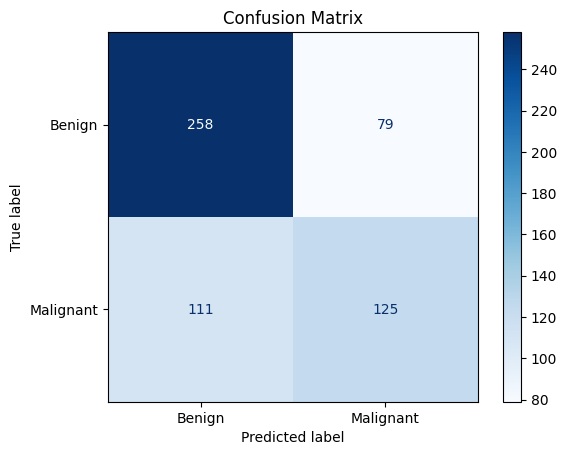

In [8]:
# Import additional necessary libraries
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get the true labels from the test generator
y_true = test_generator.labels
# Predict the labels (these will be probabilities)
y_pred_prob = model.predict(test_generator, steps=len(test_generator))

# Convert predicted probabilities to binary labels (threshold at 0.5)
y_pred = (y_pred_prob > 0.5).astype(int).ravel()

# Step 2: Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])

# Plot the confusion matrix using matplotlib
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()